In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
funcs = os.listdir('functions')

for func in funcs:
    if func.startswith('__') or func == 'import_all_functions.py':
        continue
    func = func.replace('.py','')
    print(f'{func} imported')
    exec(f'from functions.{func} import *')

import_to_df imported
process_year_remod imported
get_kaggle_data imported
process_data imported


In [93]:
import pandas as pd 
import pandas_profiling as pdp
import numpy as np
import pprint as pp
import seaborn as sns
from matplotlib import pyplot as plt

pd.set_option('display.max_columns', None)

In [4]:
files = get_kaggle_data(
    competition="house-prices-advanced-regression-techniques"
    )

files downloaded for house-prices-advanced-regression-techniques competition
   test.csv
   data_description.txt
   train.csv
   sample_submission.csv
located in /competition_data/


In [5]:
input_data = import_to_df(files)

What files did we get?

In [6]:
input_data.keys()

dict_keys(['test', 'train', 'sample_submission'])

In [7]:
input_train_df = input_data['train']
input_test_df = input_data['test']

In [86]:
# Dont keep report cached - slows down notebook too much
pdp.ProfileReport(input_train_df)

profile = pdp.ProfileReport(input_train_df)
profile.to_file(output_file='PandasProfile_house_prices.html')

Summarize dataset:  92%|█████████▏| 87/95 [00:10<00:00, 191.68it/s, Calculate cramers correlation]/Users/oliverharvey/anaconda3/envs/titanic/lib/python3.8/site-packages/pandas_profiling/model/correlations.py:101: UserWarning: There was an attempt to calculate the cramers correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"cramers": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/pandas-profiling/pandas-profiling/issues
(include the error message: 'No data; `observed` has size 0.')
  warnings.warn(
Export report to file: 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]


In [9]:
pp.pprint(input_train_df.columns)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

MSSubClass needs to be categorical.  
LotFrontage has missing values - inpute these.  
Lot Area has some silly high values - might be mistake.  
Street rarely gravel.  
Alley mostly missing. has same categories as street - gravel or pave.  
Utilies only has 1 NoSeWa value, all Allpub otherwise.  
Condition1 and 2 both contain same - transform to one hots shared.  
YearRemodAdd has suspicious peak in 1950 - maybe seperate this as a before 1950 flag and remove from column.  
YearRemodAdd is same as construction date if no remod - compare these and maybe remove the ones that arent remods.  
Exterior has 2 columns - transform into shared one hots.  
Count how many materials exterior is made from.  
MSSubClass has few missing values.  
MasVnrArea has lots of zeros - seperate as a flag?  
MSSubClass missing values.  
BsmtCond missing values.  
BsmtExposure missing values.  
BsmtFinType1 missing values.  
BsmtFinType2 missing and duplicates BsmtFinType1 - make into 1 hots should fix this.  
count how many basement fintypes there arent.  
BsmtFinSF1 lots of 0s.  
BsmtFinSF2 lots of 0s.  
These relate to FinTypes so also create categories of sqfoot per fintypes.  
2ndFlrSF lots of 0s - presumably no 2nd floor. better as seperate flag.  
LowQualFinSF mostly 0s.  
All categorical quality columns better as number probably.  
FireplaceQu missing values where no Fireplace.  
Garagetype missing values for no garage.  
GarageYrBuilt and finish and quality missing values for no garage.  
Other garage variables 0s for no garage.  
WooddeckSF 0s.  
OpenPorchSF 0s.  
Other porch columns 0s.  
Fence mostly missing.  
MiscFeature mostly missing but ok as 1 hots.  
MiscValue mostly 0s and then high values.  
MoSold should be categorical.  
Sale price could be tricky - maybe combine with year sold. Do we need to calculate inflation by area?  
Check for columns that are ordinal catagories and make into number as well.  

In [71]:
dummy_cols = ['MSSubClass', 'MSZoning', 'Alley', 'MoSold', 'SaleType']
# these ones need combining after turning into dummies since values spread over pairs of columns
dummy_pairs = {
    'Condition': ['Condition1', 'Condition2'],
    'Exterior': ['Exterior1st', 'Exterior2nd'],
    'BsmtFinType': ['BsmtFinType1', 'BsmtFinType2', 'LowQualFinSF']
}

# these ones have values that correspond to the categories so make dummies afterwards but also make these first
value_dummies = {
    'BsmtFinTypeSF': (['BsmtFinType1', 'BsmtFinType2'], ['BsmtFinSF1', 'BsmtFinSF2'])
}
impute_cols = ['LotFrontage']
zero_flags = [
    'MasVnrArea', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'LowQualFinSF', 'GarageYrBlt', 
    'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'
]
drop_cols = ['Utilities']

quality_cols_convert = [
    'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
    'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional',
    'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence'
]

columns_to_calculate_years_since =[
    ('YearBuilt', 'YrSold'),
    ('YearRemodAdd', 'YrSold'),
]

In [11]:
input_train_df['YearRemodAdd'].describe()

count    1460.000000
mean     1984.865753
std        20.645407
min      1950.000000
25%      1967.000000
50%      1994.000000
75%      2004.000000
max      2010.000000
Name: YearRemodAdd, dtype: float64

Missing values in LotFrontage. Is it specific lot shapes?

In [28]:
lotshape_stats = (
    input_train_df
        .groupby('LotShape')
        .agg({
            'LotFrontage': [
                lambda x: x.isna().sum(), 
                'count', 
                'mean']
            })
)

lotshape_stats.columns = lotshape_stats.columns.droplevel(0)
lotshape_stats.rename(columns={'<lambda_0>': 'missing'}, inplace=True)
lotshape_stats['missing_pct'] = (
    lotshape_stats['missing'] /
    (lotshape_stats['missing'] + lotshape_stats['count'])
)
lotshape_stats

,missing,count,mean,missing_pct
LotShape,,,,
IR1,167.0,317,76.094637,0.345041
IR2,15.0,26,76.500000,0.365854
IR3,3.0,7,138.428571,0.300000
Reg,74.0,851,67.038778,0.080000


Seems to be fairly high in the irregular shaped lots.  
Hopefully using decent inputer will pick up on this.  

Take a look a LotArea outliers in more detail.  

In [35]:
display(input_train_df['LotArea'].describe())
display(input_train_df.loc[
    input_train_df['LotArea'] > 12_000,
    :].sort_values('LotArea', ascending=False)
)

count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
max      215245.000000
Name: LotArea, dtype: float64

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
313,314,20,RL,150.0,215245,Pave,NaN,IR3,Low,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,375000
335,336,190,RL,NaN,164660,Grvl,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,Shed,700,8,2008,WD,Normal,228950
249,250,50,RL,NaN,159000,Pave,NaN,IR2,Low,AllPub,...,0,NaN,NaN,Shed,500,6,2007,WD,Normal,277000
706,707,20,RL,NaN,115149,Pave,NaN,IR2,Low,AllPub,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,302000
451,452,20,RL,62.0,70761,Pave,NaN,IR1,Low,AllPub,...,0,NaN,NaN,NaN,0,12,2006,WD,Normal,280000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115,1116,20,RL,93.0,12085,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,11,2007,New,Partial,318000
988,989,60,RL,NaN,12046,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,195000
238,239,20,RL,93.0,12030,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2007,New,Partial,318000
359,360,60,RL,78.0,12011,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,280000


Ok does seem like a calculation error but since using decision tree based algos prob not a big issue at this stage and don't know if its definitely wrong.  

Whats going on with multiple exteriors? Would expect them to be null if only 1 but there are no missing values. 
Maybe they have repeated the first material?

In [26]:
input_train_df.loc[input_train_df['Exterior1st'] == input_train_df['Exterior2nd'], ['Exterior1st', 'Exterior2nd']]

,Exterior1st,Exterior2nd
0,VinylSd,VinylSd
1,MetalSd,MetalSd
2,VinylSd,VinylSd
4,VinylSd,VinylSd
5,VinylSd,VinylSd
...,...,...
1454,VinylSd,VinylSd
1455,VinylSd,VinylSd
1456,Plywood,Plywood
1458,MetalSd,MetalSd


Yes thats whats happened. Developed a function that will create one hots from two columns and doesnt care about duplicates

<AxesSubplot:>

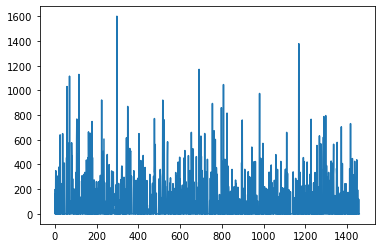

In [59]:
input_train_df['MasVnrArea'].plot()

Not actually that many 0s but added flag anyway

In [61]:
input_train_df[['BsmtFinType1', 'BsmtFinType2', 'BsmtFinSF1', 'BsmtFinSF2']]

,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2
0,GLQ,Unf,706,0
1,ALQ,Unf,978,0
2,GLQ,Unf,486,0
3,ALQ,Unf,216,0
4,GLQ,Unf,655,0
...,...,...,...,...
1455,Unf,Unf,0,0
1456,ALQ,Rec,790,163
1457,GLQ,Unf,275,0
1458,GLQ,Rec,49,1029


In [70]:
input_train_df['KitchenQual'].value_counts()

TA    735
Gd    586
Ex    100
Fa     39
Name: KitchenQual, dtype: int64

Now lets look at the trends of prices over time. First question - is there any time criteria in how they have split test and control? Its not stated on the website

In [83]:
input_train_df['YrSold'].value_counts()

2009    338
2007    329
2006    314
2008    304
2010    175
Name: YrSold, dtype: int64

In [82]:
input_test_df['YrSold'].value_counts()

2007    363
2008    318
2009    309
2006    305
2010    164
Name: YrSold, dtype: int64

Seems fine, similar distribution across both sets. So year of sale will be important. Maybe its worth looking at inflation by area over time

In [101]:
test = process_data(input_train_df)

In [102]:
pd.set_option('max_rows', None)
test.head(2).T

,0,1
Id,1,2
LotFrontage,65.0,80.0
LotArea,8450,9600
Street,Pave,Pave
LotShape,Reg,Reg
LandContour,Lvl,Lvl
LotConfig,Inside,FR2
LandSlope,Gtl,Gtl
Neighborhood,CollgCr,Veenker
BldgType,1Fam,1Fam
